# Прогнозирование оттока клиентов «Ниединогоразрыва.ком»

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (*DSL*, от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Описание полей данных:
- `customerID` – код клиента,
- `BeginDate` – дата начала пользования услугами,
- `EndDate` – дата окончания пользования услугами,
- `Type` – тип оплаты: ежемесячный, годовой и тд,
- `PaperlessBilling` – безналичный расчет,
- `PaymentMethod` – способ оплаты,
- `MonthlyCharges` – ежемесячные траты на услуги,
- `TotalCharges` – всего потрачено денег на услуги
- `Dependents` – наличие иждивенцев
- `Senior Citizen` – наличие пенсионного статуса по возрасту
- `Partner` – наличие супруга(и)
- `MultipleLines` – наличие возможности ведения параллельных линий во время звонка

Информация о договорах актуальна на 1 февраля 2020.

# План проекта
- Загрузить и проанализировать данные, подготовить их к предобработке
- Провести предобработку данных перед использованием в моделях
- Обучить несколько моделей, выбрать лучшую
- Провести финальное тестирование качества лучшей модели и сформулировать выводы
- Подготовить отчет по проекту

# Загрузка и анализ данных

Подключим необходимые библиотеки и выставим полезные умолчания.

In [1]:
# !pip install optuna catboost -U

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import math

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

from catboost import CatBoostClassifier, Pool

from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution

from scipy.stats import loguniform

plt.style.use('dark_background');            # Dark theme for plots
plt.rc('grid', color=(.3, .3, .3));          # Pale grid lines
plt.rc('axes', grid=True, axisbelow=True);   # Grid lines behind the plot
pd.set_option('display.max_columns', None);  # Display all dataframe columns
# pd.set_option('display.max_rows', 100);      # Display 100 dataframe rows

In [2]:
RS = 290822  # Custom random state

Напишем функцию для трансформации названий полей из "верблюжьего" регистра в  "змеиный".

In [3]:
def camel_to_snake(string):
    '''Converts string from CamelCase to snake_case'''
    string = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', string)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', string).lower()

Напишем функцию, которая выводит гистограммы для каждого поля из датафрейма.

In [4]:
def plot_hists(df, title=None, ncols=3, exclude=['customer_id']):
    '''Plots a histogram for each column in dataframe'''
    
    nrows = math.ceil(df.shape[1] / ncols)
    colors = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

    plt.figure(figsize=(6*ncols, 4*nrows), constrained_layout=True)
    plt.suptitle(title, fontsize='xx-large');
    # plt.subplots_adjust(wspace=.2, hspace=.4);
    
    for i, col in enumerate(df.drop(columns=exclude, errors='ignore')):
        ax = plt.subplot(nrows, ncols, i+1);
        ax.set_title(f'{col}');
        params = dict(ax=ax, color=colors[i % len(colors)])
        if df[col].dtypes in ['object', 'category']:
            df[col].value_counts().plot.barh(**params);
            ax.set(xlabel='Number of samples', ylabel='Value');
        else:
            df[col].hist(bins=20, edgecolor='k', **params);
            ax.set(xlabel='Value', ylabel='Number of samples');     

Загрузим данные в датафреймы, названия которых соответствуют источнику, и сразу трансформируем наименования полей в них.

In [5]:
for df in ['contract', 'internet', 'personal', 'phone']:
    globals()[df] = pd.read_csv(f'{df}.csv')

In [6]:
for df in [contract, internet, personal, phone]:
    df.columns = map(camel_to_snake, df.columns)    

## Договоры

Взглянем на информацию о договорах.

In [7]:
contract

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [8]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [9]:
contract.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64

In [10]:
contract.duplicated().sum()

0

Явных пропусков и дублей нет, но типы данных не везде соответствуют содержанию столбцов. Приведем поля с датами к типу datetime.

In [11]:
contract['end_date'] = contract['end_date'].replace('No', np.nan)
contract[['begin_date', 'end_date']] = contract[['begin_date', 'end_date']].apply(pd.to_datetime, format='%Y-%m-%d')

Приведем поле `total_charges` к числовому типу.

In [12]:
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')

In [13]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [14]:
contract.isna().sum()

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
dtype: int64

Появились пропуски в столбце `end_date` – это нормально, так как не все клиенты прекратили пользоваться услугами компании. Взглянем на пропуски в столбце `total_charges`.

In [15]:
contract[contract['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN


Это 11 клиентов, которые начали пользоваться услугами компании в день выгрузки данных – 1 февраля 2020. Для них еще не рассчитаны общие затраты на услуги. Логичным решением будет заполнить такие пропуски нулями.

In [16]:
contract['total_charges'] = contract['total_charges'].fillna(0)

Проверим, нет ли других клиентов, подключившихся 1 февраля 2020.

In [17]:
contract[contract['begin_date'] == '2020-02-01']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,0.0
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,0.0
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,0.0
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,0.0
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,0.0
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,0.0
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,0.0
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,0.0
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,0.0
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,0.0


Других нет.

Посмотрим на гистограммы каждого столбца.

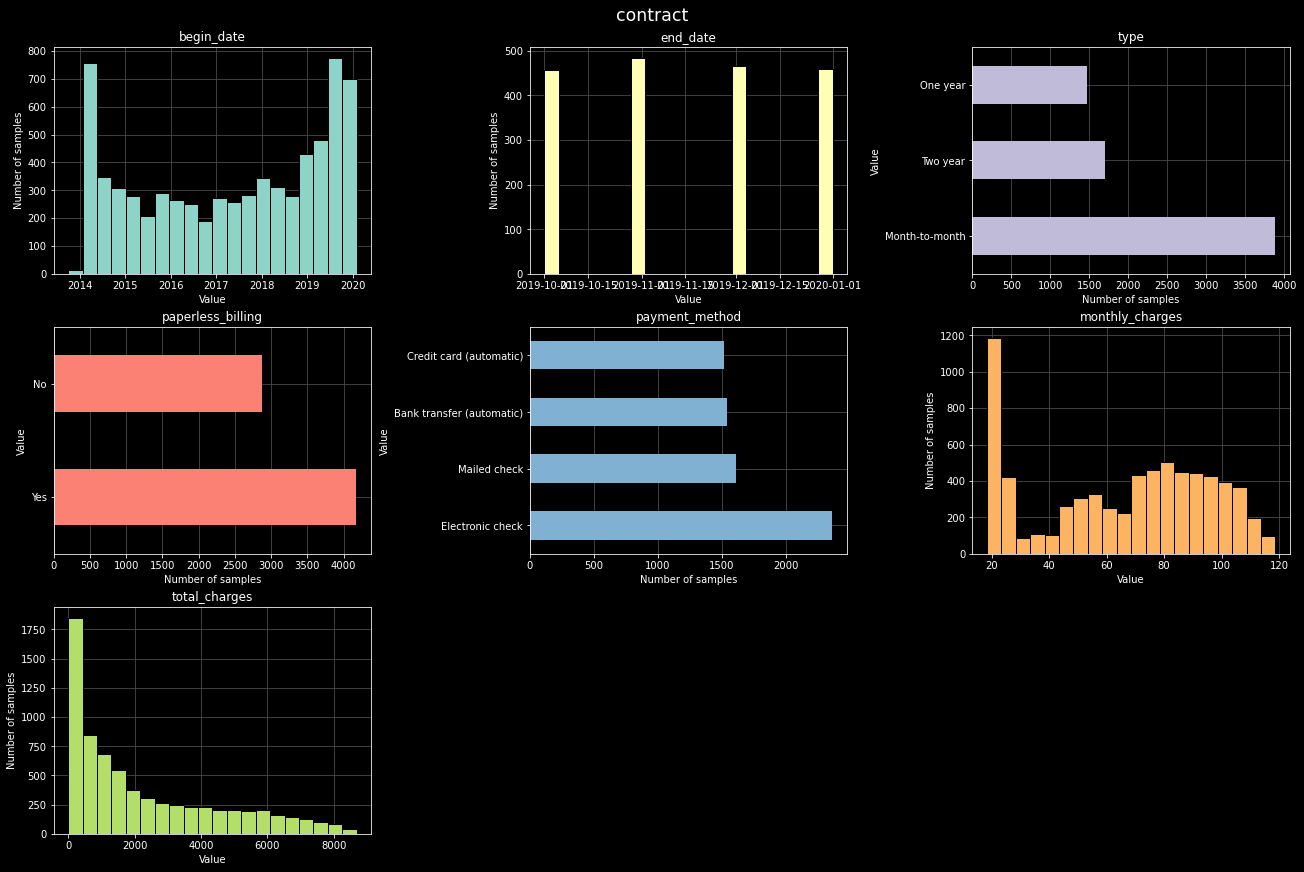

In [18]:
plot_hists(contract, 'contract')

Ничего необычного, кроме поля `end_date`: пользователи прекращали пользоваться услугами компании всего в 4 разные даты:

In [19]:
contract['end_date'].value_counts().sort_index()

2019-10-01    458
2019-11-01    485
2019-12-01    466
2020-01-01    460
Name: end_date, dtype: int64

Это 1 октября, 1 ноября, 1 декабря 2019 и 1 января 2020, то есть последние четыре месяца перед выгрузкой данных. 

Убедимся, что даты *начала* пользования услугами тоже указаны с точностью до месяца.

In [20]:
contract['begin_date'].dt.day.value_counts()

1    7043
Name: begin_date, dtype: int64

Так и есть.

## Клиенты

Взглянем на персональную информацию о клиентах.

In [21]:
personal

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [22]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [23]:
personal.isna().sum()

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

In [24]:
personal.duplicated().sum()

0

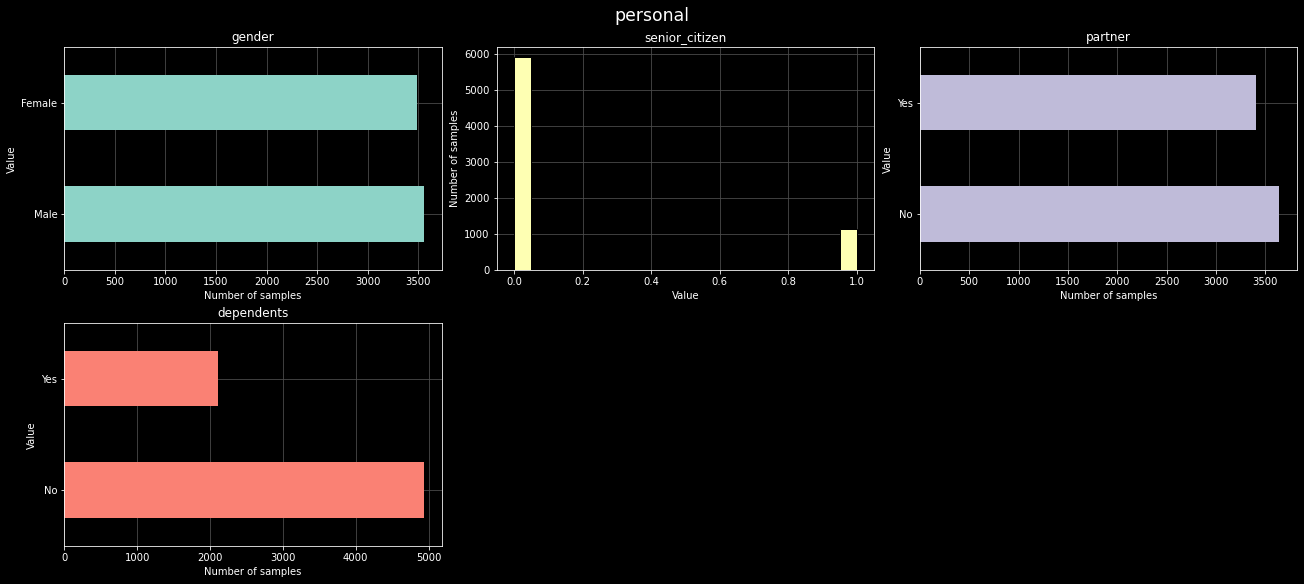

In [25]:
plot_hists(personal, 'personal')

Пропусков и дублей нет, гистограммы в норме.

## Интернет

Взглянем на информацию об интернет-услугах.

In [26]:
internet

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [27]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [28]:
internet.isna().sum()

customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

In [29]:
internet.duplicated().sum()

0

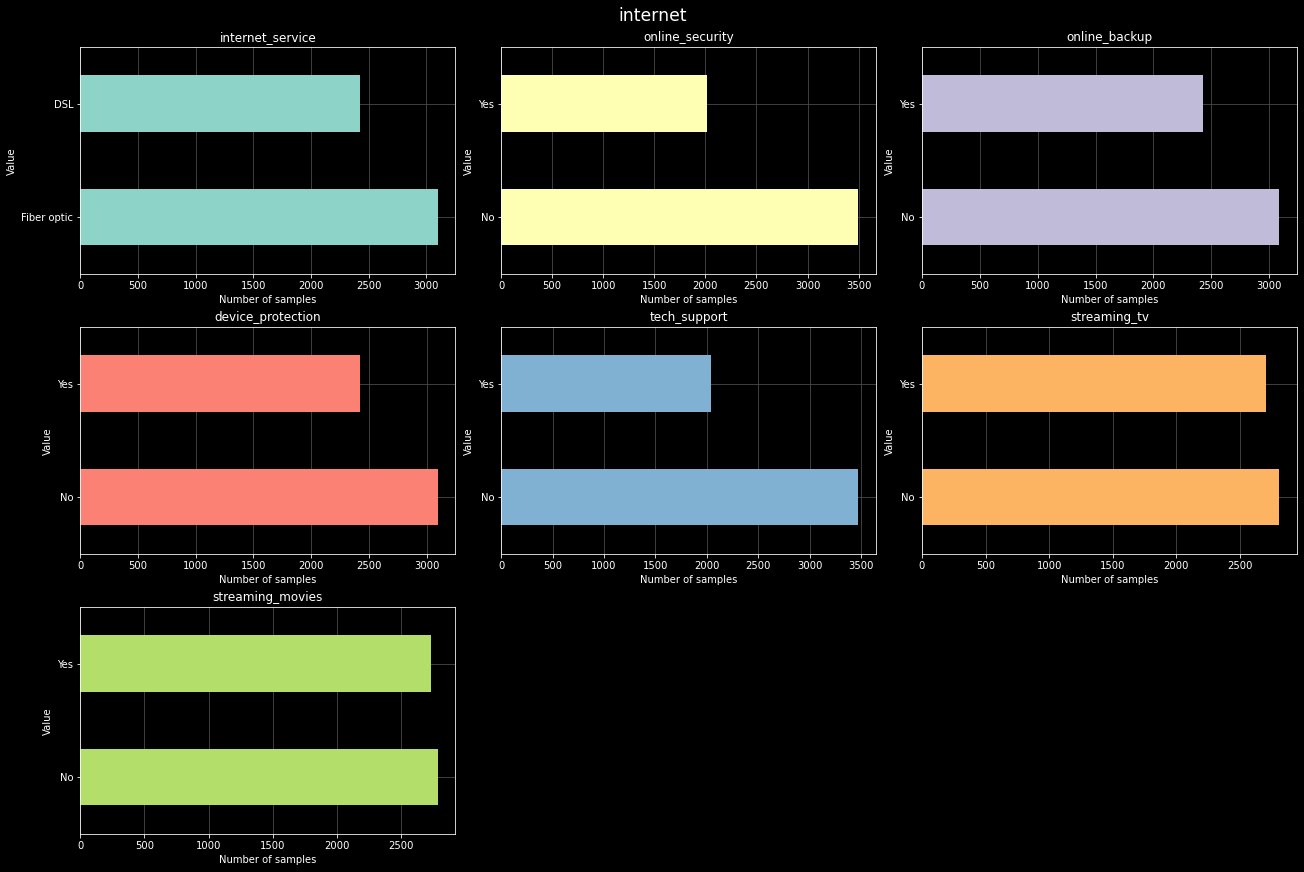

In [30]:
plot_hists(internet, 'internet')

Пропусков и дублей нет, гистограммы не вызывают вопросов.

## Телефония

Наконец, взглянем на услуги телефонии.

In [31]:
phone

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [32]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [33]:
phone.isna().sum()

customer_id       0
multiple_lines    0
dtype: int64

In [34]:
phone.duplicated().sum()

0

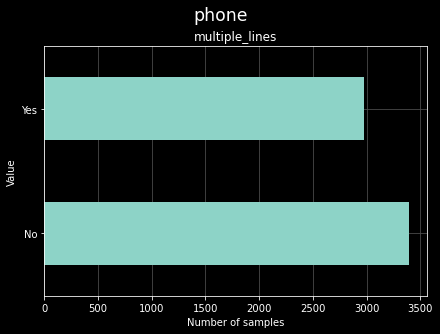

In [35]:
plot_hists(phone, 'phone', ncols=1)

Ни пропусков, ни дублей, гистограмма ок.

## Объединение данных

Объединим все данные в один датафрейм.

In [36]:
df = (
    contract
    .merge(personal, how='left', on='customer_id')
    .merge(internet, how='left', on='customer_id')
    .merge(phone, how='left', on='customer_id')
)

In [37]:
df

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,1990.50,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,7362.90,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [39]:
df.isna().sum()

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

1526 клиентов не пользуются услугами интернета, а 682 клиента – услугами телефонии. Проверим, нет ли клиентов, не пользующихся ни интернетом, ни телефонией.

In [40]:
df[df['internet_service'].isna() & df['multiple_lines'].isna()].shape

(0, 20)

Таких нет – это хорошо.

Пропуски в полях `internet_service` и `multiple_lines` заполним прочерком, чтобы пометить клиентов, у которых не подключена услуга интернета, и отделить клиентов без телефонии от клиентов с одной телефонной линией.

In [41]:
columns = ['internet_service', 'multiple_lines']
df[columns] = df[columns].fillna('-')

Пропуски в столбцах `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv` и `streaming_movies` заменим на `No` как отсутствие услуги.

In [42]:
columns = [
    'online_security', 
    'online_backup', 
    'device_protection', 
    'tech_support', 
    'streaming_tv', 
    'streaming_movies',
]
df[columns] = df[columns].fillna('No')

Наконец, взглянем на гистограммы столбцов в итоговом датафрейме.

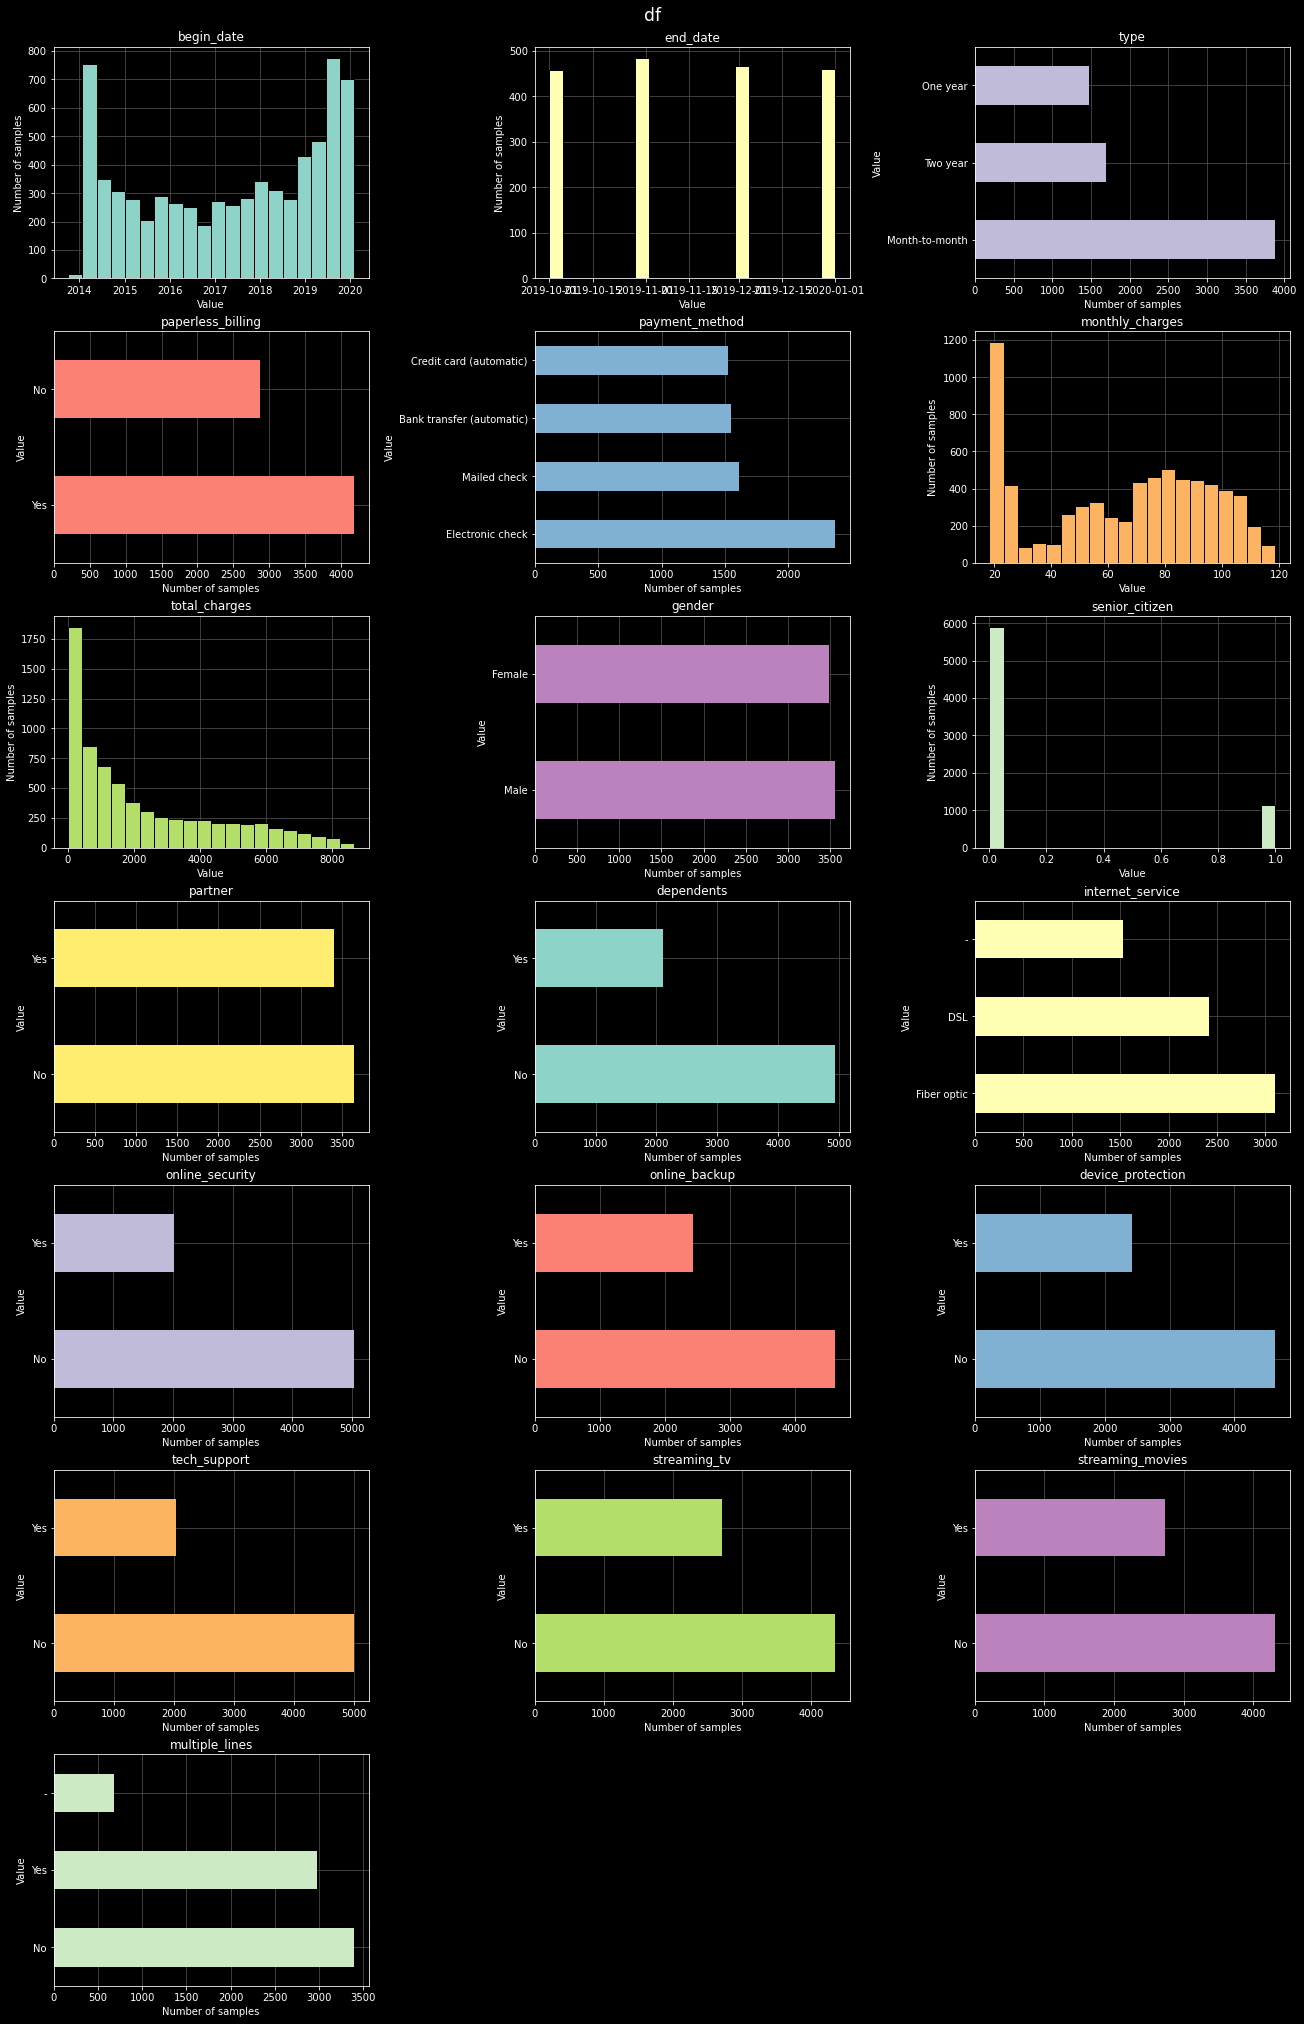

In [43]:
plot_hists(df, 'df')

## Выводы

Данные чистые, непротиворечивые, с большим количеством категориальных фичей. Потребуется предобработка.

# Предобработка данных

Заменим поле `begin_date` столбцом `duration`, в который запишем число месяцев, прошедшее с момента подписания контракта до даты выгрузки данных – 1 февраля 2020. Информацию мы при этом не потеряем, зато сможем использовать модели, которые работают только с числами в качестве фичей. 

In [56]:
today = pd.to_datetime('2020-02-01')
df['duration'] = (
    today 
    # df['end_date'].fillna(today) 
    - df['begin_date']
).astype('timedelta64[M]').astype('uint16')

In [57]:
df = df.drop(columns='begin_date')

Создадим таргет – поле `quit`, принимающее значение 1, если клиент ушел, и 0, если нет. После этого удалим поле `end_date`, которое больше не нужно.

In [58]:
df['quit'] = df['end_date'].notna().astype('uint8')

In [59]:
df = df.drop(columns='end_date')

Удалим также поле `customer_id` как неинформативное.

In [60]:
df = df.drop(columns='customer_id')

Посмотрим на результат.

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   int64  
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines     7043 

In [62]:
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration,quit
0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,-,1,0
1,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,34,0
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,4,1
3,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,-,45,0
4,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,5,1


Отделим таргет от фичей.

In [63]:
x = df.drop(columns='quit')
y = df['quit']

Приведем все категориальные фичи к категориальному типу данных, чтобы создаваемый ниже трансформер-предобработчик фич смог их автоматически идентифицировать.

In [64]:
cat_x = x.select_dtypes('object').columns.to_list() + ['senior_citizen']
# num_x = [col for col in x.columns if col not in cat_x]

x[cat_x] = x[cat_x].astype('category')

Разделим датасет на обучающую и тестовую выборки.

In [65]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=.25, stratify=y, random_state=RS)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)
print(f'{y.mean():.4f}, {y_train.mean():.4f}, {y_test.mean():.4f}')

(5282, 18) (1761, 18)
(5282,) (1761,)
0.2654, 0.2654, 0.2652


# Обучение моделей

Создадим трансформер-предобработчик фич, чтобы далее использовать его в пайплайнах с моделями: числовые фичи он будет скейлить, а категориальные – ванхотэнкодить.

In [66]:
num_tformer = StandardScaler()
cat_tformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preproc = ColumnTransformer([
        ('num', num_tformer, make_column_selector(dtype_include='number')),
        ('cat', cat_tformer, make_column_selector(dtype_include='category')),
], remainder='passthrough')

## Dummy

Сначала проверим качество dummy-модели, которая возвращает случайные предсказания, стратифицированные по таргету.

In [67]:
print('Dummy mean CV scores:')
for scoring in ['roc_auc', 'accuracy']:
    score = cross_val_score(
        DummyClassifier(strategy='stratified', random_state=RS),
        x_train, y_train,
        scoring=scoring,
        cv=5,
    ).mean()
    print(f"    {scoring}: {score:.3f}")

Dummy mean CV scores:
    roc_auc: 0.498
    accuracy: 0.602


ROC AUC, ожидаемо, около 0,5, Accuracy немного выше из-за дисбаланса классов.

## Logit

Теперь обучим модель логистической регрессии. Для этого поставим ее в пайплайн после трансформера-предобработчика фич и подберем гиперпараметры с помощью `GridSearchCV`.

In [68]:
logit_pipe = Pipeline([
    ('preproc', preproc), 
    ('logit', LogisticRegression(max_iter=10000, random_state=RS)),
])

In [69]:
c_grid = np.logspace(-3, 0, 7)
l1_ratio_grid = [.1, .5, .7, .9, .95, .99, 1]
logit_grid = [
    dict(
        logit__penalty=['l1'], 
        logit__solver=['liblinear'], #'saga'],
        logit__C=c_grid,
    ),
    dict(
        logit__penalty=['l2'], 
        logit__solver=['newton-cg', 'lbfgs', 'liblinear'], #'sag', 'saga'],
        logit__C=c_grid,
    ),
    dict(
        logit__penalty=['none'],
        logit__solver=['newton-cg', 'lbfgs'], #'sag', 'saga'],
    ),
    dict(
        logit__penalty=['elasticnet'], 
        logit__solver=['saga'],
        logit__C=c_grid,
        logit__l1_ratio=l1_ratio_grid,
    ),
]
print('Number of Candidates:',
      sum([np.prod([len(lst) for lst in dct.values()]) for dct in logit_grid]))

Number of Candidates: 79


In [70]:
%%time
logit = GridSearchCV(
    estimator=logit_pipe, 
    param_grid=logit_grid,   
    scoring='roc_auc', 
    cv=5,
    verbose=10,
    n_jobs=-1,
).fit(x_train, y_train);

print()
print('Logit estimator:')
print(logit.cv_results_['params'][logit.cv_results_['rank_test_score'].argmin()])
print()

Fitting 5 folds for each of 79 candidates, totalling 395 fits

Logit estimator:
{'logit__penalty': 'none', 'logit__solver': 'lbfgs'}

CPU times: total: 2.67 s
Wall time: 21 s


Проверим качество модели на кросс-валидации обучающей выборки.

In [71]:
print('Logit mean CV scores:')
print(f'    ROC AUC: {logit.best_score_:.3f}')
accuracy = cross_val_score(
    logit.best_estimator_,
    x_train, y_train,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
).mean()
print(f'    Accuracy: {accuracy:.3f}')     

Logit mean CV scores:
    ROC AUC: 0.840
    Accuracy: 0.800


Обе метрики у логита выше, чем у dummy-модели – это хорошо.

## Forest

Следующей моделью будет случайный лес. Эта модель нечувствительна к масштабу числовых фич, поэтому скейлер из трансформера-предобработчика можно убрать. Подбирать гиперпараметры будем с помощью `Optuna`.

In [72]:
preproc.set_params(num='passthrough')  # Remove StandardScaler from the pipe
rf_pipe = Pipeline([
    ('preproc', preproc), 
    ('rf', RandomForestClassifier(random_state=RS, n_jobs=-1))
])

In [73]:
rf_space = dict(
    rf__n_estimators=IntDistribution(2, 1000),
    rf__max_depth=IntDistribution(2, 30),
)

In [74]:
%%time
forest = OptunaSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_space,
    cv=5,
    n_trials=100,
    scoring='roc_auc',
    random_state=RS,
).fit(x_train, y_train)

print()
print('Forest estimator:')
print(forest.best_params_)
print()

<timed exec>:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2022-09-18 23:19:40,115] A new study created in memory with name: no-name-47fd77c3-a685-43fd-b5b9-5afe9045e90e
[I 2022-09-18 23:19:47,934] Trial 0 finished with value: 0.8739773662335757 and parameters: {'rf__n_estimators': 796, 'rf__max_depth': 11}. Best is trial 0 with value: 0.8739773662335757.
[I 2022-09-18 23:19:56,073] Trial 1 finished with value: 0.8761299079790774 and parameters: {'rf__n_estimators': 783, 'rf__max_depth': 29}. Best is trial 1 with value: 0.8761299079790774.
[I 2022-09-18 23:20:03,401] Trial 2 finished with value: 0.8759251719086578 and parameters: {'rf__n_estimators': 680, 'rf__max_depth': 26}. Best is trial 1 with value: 0.8761299079790774.
[I 2022-09-18 23:20:11,452] Trial 3 finished with value: 0.8701902263638699 and parameters: {'rf__n_estimators': 982, 'rf__max_depth': 9}. Best is trial 1 with value: 0.8761299079790774.
[


Forest estimator:
{'rf__n_estimators': 892, 'rf__max_depth': 16}

CPU times: total: 12min 13s
Wall time: 13min 55s


Проверим качество модели.

In [75]:
print('Forest mean CV scores:')
print(f'    ROC AUC: {forest.best_score_:.3f}')
accuracy = cross_val_score(
    forest.best_estimator_,
    x_train, y_train,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
).mean()
print(f'    Accuracy: {accuracy:.3f}')     

Forest mean CV scores:
    ROC AUC: 0.876
    Accuracy: 0.837


Обе метрики у леса выше, чем у логита – лес пока лидирует.

## CatBoost

Наконец, обучим отраслевой стандарт – модель градиентного бустинга `CatBoost`. Эта модель нечувствительна к масштабу числовых фич и умеет обрабатывать категориальные фичи, поэтому предобработчик фич для нее не нужен. Подбирать `learning_rate` будем с помощью метода `randomized_search`.

In [76]:
%%time

n_iter = 10  # The number of parameter settings sampled with randomized_search 

np.set_printoptions(formatter={'float_kind': '{:.4f}'.format})
np.random.seed(RS)
cat_space = dict(learning_rate=loguniform(.01, 1))
print('Learning rates:', cat_space['learning_rate'].rvs(size=n_iter))
print()

cat_params = dict(
    iterations=1000,
    loss_function='Logloss',
    eval_metric='AUC',
    custom_metric=['Accuracy'], 
    random_seed=RS,
    logging_level='Silent',
)

cat = CatBoostClassifier(**cat_params)

np.random.seed(RS)
cat_cv = cat.randomized_search(
    cat_space,
    Pool(x_train, y_train, cat_features=cat_x),
    cv=5, 
    n_iter=n_iter,
    search_by_train_test_split=False,
    stratified=True,
    refit=True,
    partition_random_seed=RS,
    plot=True,
    verbose=False,
)

print()
print('CatBoost estimator:')
print(cat_cv['params'])
print()

Learning rates: [0.2313 0.0564 0.0341 0.0772 0.0360 0.0323 0.3579 0.4516 0.0314 0.0115]



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate

Проверяем качество модели на кросс-валидации.

In [77]:
cat_cv = pd.DataFrame(cat_cv['cv_results'])
best_iter = cat_cv['test-AUC-mean'].idxmax()
print('CatBoost best iteration:', best_iter)
print('CatBoost mean CV scores:')
print(f"    ROC AUC: {cat_cv.loc[best_iter, 'test-AUC-mean']:.3f}")
print(f"    Accuracy: {cat_cv.loc[best_iter, 'test-Accuracy-mean']:.3f}")   

CatBoost best iteration: 990
CatBoost mean CV scores:
    ROC AUC: 0.934
    Accuracy: 0.896


 `CatBoost` опережает случайный лес по обеим метрикам и выходит в финал.

# Тестирование лучшей модели

Обрежем модель `CatBoost` до оптимального числа деревьев.

In [78]:
cat.shrink(best_iter+1)

Теперь протестируем модель на тестовой выборке.

In [79]:
y_proba = cat.predict_proba(Pool(x_test, y_test, cat_features=cat_x))[:, 1]
y_pred = 1*(y_proba >= .5)

In [80]:
print('CatBoost test scores:')
print(f"    ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"    Accuracy: {accuracy_score(y_test, y_pred):.3f}")

CatBoost test scores:
    ROC AUC: 0.938
    Accuracy: 0.900


Качество модели на тестовой выборке почти не отличается от качества на кросс-валидации обучающей выборки.

# Выводы

- Были обучены четыре модели: dummy, логистическая регрессия, случайный лес и градиентный бустинг `CatBoost`
- Наилучшее качество на кросс-валидации обучающей выборки показала модель `CatBoost`: ROC AUC = 0.934, Accuracy = 0.896
- Качество модели `CatBoost` на тестовой выборке практически идентично качеству на кросс-валидации обучающей: ROC AUC = 0.938, Accuracy = 0.900